<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_4_multilingual_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This Notebook:

*   TOKEN CLASSIFICATION - NER (PAN-X)
*   Multilingual [de, fr, it, en]
*   EDA
*   Multilingual Transformers model XLM-R
*   SentencePiece tokenizer vs WordPiece tokenizer
*   Create Custom Model.
*   Fine-Tuning XLM-RoBERTa
*   Error analysis
*   Cross-Lingual Transfer

The final models: 
* https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-de (train only on de)

* https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-de-fr (train on de and fr)

* https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all (train on de, fr, it, en)




In [ ]:
!pip install transformers[sentencepiece] datasets

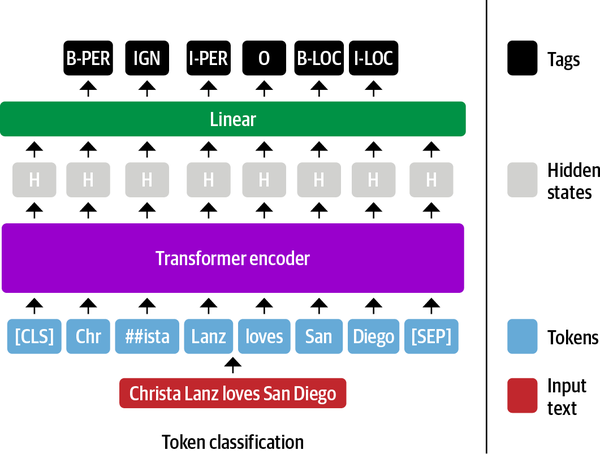

# DATA

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations For example {xtreme_subsets[0:10]}")

XTREME has 183 configurations For example ['XNLI', 'tydiqa', 'SQuAD', 'PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de', 'PAN-X.el', 'PAN-X.en']


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:10]

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu']

In [4]:
from collections import defaultdict
from datasets import DatasetDict, load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    print(type(ds))
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.dataset_dict.DatasetDict'>


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.dataset_dict.DatasetDict'>


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.dataset_dict.DatasetDict'>


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [5]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict, {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }), 'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                  

In [6]:
panx_ch['en']

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 1180
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
})

In [7]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
# data = {'a':456, 'b':674}
# pd.DataFrame(data, index=["Asd"]).plot(kind="barh")

In [8]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags,  tags.int2str(4), tags.str2int('I-PER')

(ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None),
 'I-ORG',
 2)

In [11]:
def create_tag_names(sample):
    return {"ner_tags_str": [tags.int2str(idx) for idx in sample["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [12]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], index=['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# Multilingual Transformers XLM-R

Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages.

In [ ]:
# SentencePiece compares to WordPiece
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)  # WordPiece
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)  # SentencePiece

In [15]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()
"bert:", bert_tokens, "xlm:" ,xlmr_tokens

('bert:',
 ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 'xlm:',
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

In [16]:
bert_tokenizer(text), xlmr_tokenizer(text)

({'input_ids': [101, 2132, 23665, 8674, 7871, 1203, 1365, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 21763, 37456, 15555, 5161, 7, 2356, 5753, 38, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

In [17]:
xlmr_tokenizer("שלום קוראים לי נעם שמשוביץ ובגלל שזה מודל למלא שפות אני מנסה אותו בעברית")

{'input_ids': [0, 56976, 58571, 24390, 3944, 6, 119132, 114762, 147065, 5110, 21847, 1644, 55920, 7038, 55546, 657, 100378, 1751, 21527, 4892, 179019, 15415, 211915, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
xlmr_tokenizer("שלום קוראים לי נעם שמשוביץ ובגלל שזה מודל למלא שפות אני מנסה אותו בעברית").tokens()

['<s>',
 '▁שלום',
 '▁קור',
 'אים',
 '▁לי',
 '▁',
 'נעם',
 '▁שמש',
 'וביץ',
 '▁וב',
 'גל',
 'ל',
 '▁שזה',
 '▁מו',
 'דל',
 '▁ל',
 'מלא',
 '▁ש',
 'פות',
 '▁אני',
 '▁מנסה',
 '▁אותו',
 '▁בעברית',
 '</s>']

#Using AutoModelForTokenClassification

the body of a model is implemented in a class such as BertModel or GPT2Model or AutoModel that returns the hidden states of the last layer. 

Task-specific models such as BertForMaskedLM or BertForSequenceClassification or AutoModelForTokenClassification use the base model and add the necessary head on top of the hidden state.

using AutoModelForTokenClassification to learn from 'de' to 'de'

In [22]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


In [23]:
xlmr_model_name

'xlm-roberta-base'

In [24]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, 
                                         label2id=tag2index)



In [25]:
from transformers import AutoModelForTokenClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = AutoModelForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

In [27]:
# check the model
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
print(text, input_ids)
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

Jack Sparrow loves New York! tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


**instead of using the AutoModelForTokenClassification let's build this from scratch!**

# Creating a Custom Model for Token Classification

Let’s go through the exercise of building a custom token classification head for XLM-R. Since XLM-R uses the same model architecture as RoBERTa, we will use RoBERTa as the base model, but augmented with settings specific to XLM-R

In [28]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [29]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    #config_class = XLMRobertaConfig # The config_class ensures that the standard XLM-R settings are used when we initialize a new model

    def __init__(self, config):
        super().__init__(config)  # call the initialization function of the RobertaPreTrainedModel class
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False) # False - to ensure all hidden states are returned and not only the one associated with the [CLS] token
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()  # method we inherit from RobertaPreTrainedModel, which will load the pretrained weights for the model body and randomly initialize the weights of our token classification head

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        #print("self.roberta outputs:", outputs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions) 
                                     #outputs

# Loading a Custom Model
Let’s have a look how we can load pretrained weights into our custom model.


In [30]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


In [31]:
xlmr_model_name, tags.num_classes

('xlm-roberta-base', 7)

In [32]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, 
                                         label2id=tag2index)
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

The AutoConfig class contains the blueprint of a model’s architecture. When we load a model with AutoModel.from_pretrained(model_ckpt), the configuration file associated with that model is downloaded automatically. 

**However, if we want to modify something like the number of classes or label names, then we can load the configuration first with the parameters we would like to customize.**

Now, we can load the model weights as usual with the from_pretrained() function with the additional config argument. Note that we did not implement loading pretrained weights in our custom model class; we get this for free by inheriting from RobertaPreTrainedModel:

In [33]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'roberta.e

In [34]:
xlmr_model.classifier

Linear(in_features=768, out_features=7, bias=True)

In [ ]:
# check the model
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
print(text, input_ids)
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])


Jack Sparrow loves New York! tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
#outputs, body_output = xlmr_model(input_ids.to(device))
outputs = xlmr_model(input_ids.to(device))

In [ ]:
#body_output

In [ ]:
#body_output.last_hidden_state.shape # bs, tokens, features

In [ ]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.0979,  0.1492, -0.9578,  0.3555, -0.1904,  0.2149,  0.0932],
         [-0.1790, -0.0767, -1.1192,  0.3889,  0.0247,  0.3135,  0.0353],
         [-0.2768, -0.0667, -1.0390,  0.3367,  0.0258,  0.2718,  0.0380],
         [-0.1529, -0.0833, -1.0771,  0.3775,  0.0964,  0.2962,  0.1073],
         [-0.2175, -0.0096, -1.0525,  0.3714, -0.1259,  0.3412,  0.0104],
         [-0.1681, -0.0122, -1.0216,  0.4672, -0.0091,  0.3169, -0.0226],
         [-0.2296, -0.0105, -1.1152,  0.4752, -0.0264,  0.2949,  0.0095],
         [-0.2371, -0.0573, -1.1592,  0.4137, -0.0656,  0.2605,  0.0186],
         [-0.1912, -0.0901, -1.0450,  0.4080, -0.1398,  0.1978,  0.0826],
         [ 0.1651,  0.1409, -0.9306,  0.3302, -0.1948,  0.2262,  0.1584]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits.shape # bs, tokens, classes

torch.Size([1, 10, 7])

In [ ]:
predictions = torch.argmax(outputs.logits, dim=-1)
predictions

tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], device='cuda:0')

In [ ]:
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.logits.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [ ]:
outputs.logits.view(-1, 7).shape

torch.Size([10, 7])

In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


In [35]:
def tag_text(text, tags, model, tokenizer):
  
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)
    #print(outputs)
    outputs = outputs.logits
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [ ]:
pd.DataFrame([['a','b','c'], [0.89,0.789, 0.12]], index=["str", "float"])

,0,1,2
str,a,b,c
float,0.89,0.789,0.12


# Tokenizing Texts for NER

 Datasets provides a fast way to tokenize a Dataset object with the map() operation. To achieve this, recall that we first need to define a function with the minimal signature:

**function(examples: Dict[str, List]) -> Dict[str, List]**

where examples is equivalent to a slice of a Dataset, e.g., panx_de['train'][:10]

In [36]:
words, labels = de_example["tokens"], de_example["ner_tags"]
print(words, labels, de_example)

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'] [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0] {'tokens': ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'], 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0], 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'], 'ner_tags_str': ['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O']}


In [37]:
len(words), len(labels)

(12, 12)

In [38]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [39]:
len(tokenized_input.input_ids)

25

In [40]:
text = "Jack Sparrow loves New York!"
tokens_a = xlmr_tokenizer.convert_ids_to_tokens(xlmr_tokenizer(text)["input_ids"])
tokens_b = xlmr_tokenizer(text).tokens()
tokens_a == tokens_b

True

In [41]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


 Since we’re following the convention that only “▁Einwohner” should be associated with the B-LOC label, we need a way to mask the subword representations after the first subword

In [42]:
print(tokenized_input.word_ids(), tokenized_input.tokens())

[None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None] ['<s>', '▁2.000', '▁Einwohner', 'n', '▁an', '▁der', '▁Dan', 'zi', 'ger', '▁Buch', 't', '▁in', '▁der', '▁polni', 'schen', '▁Wo', 'i', 'wod', 'schaft', '▁Po', 'mmer', 'n', '▁', '.', '</s>']


In [43]:
word_ids = tokenized_input.word_ids()
print(word_ids)

[None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]


In [44]:
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Let’s set –100 as the label for special tokens and the subwords we wish to mask during training

In [45]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

print(label_ids)
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
print(labels)

[-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]
['IGN', 'O', 'O', 'IGN', 'O', 'O', 'B-LOC', 'IGN', 'IGN', 'I-LOC', 'IGN', 'O', 'O', 'B-LOC', 'IGN', 'B-LOC', 'IGN', 'IGN', 'IGN', 'I-LOC', 'IGN', 'IGN', 'O', 'IGN', 'IGN']


In [46]:
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [47]:
len(labels)

25

In [48]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]): # loop sentence by sentence
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [49]:
examples = panx_de["train"][3:6]
print("ner_tags",examples["ner_tags"])
tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
print("input_ids:",tokenized_inputs.input_ids)

ner_tags [[0, 0, 3, 4, 0, 0], [0, 1, 2, 2, 2], [0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]]
input_ids: [[0, 242, 5106, 46231, 13, 20130, 4432, 5106, 242, 2], [0, 1392, 6765, 821, 5, 436, 5, 3253, 1728, 2], [0, 727, 20267, 23, 122, 117366, 80938, 58823, 6, 4, 12711, 1112, 1785, 65272, 5486, 122, 224047, 542, 58823, 6, 5, 2]]


In [50]:
for idx, label in enumerate(examples["ner_tags"]):
  print(idx, label)

0 [0, 0, 3, 4, 0, 0]
1 [0, 1, 2, 2, 2]
2 [0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]


In [51]:
tokenized_inputs.word_ids(batch_index=1)

[None, 0, 1, 2, 2, 3, 3, 4, 4, None]

In [52]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [53]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [54]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

In [55]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [56]:
for k,v in panx_de_encoded['train'][0].items():
  print(k, ":", v)

input_ids : [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels : [-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]


# Performance Measures

Evaluating a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1-score. The only subtlety is that all words of an entity need to be predicted correctly in order for a prediction to be counted as correct

In [ ]:
!pip install seqeval

In [58]:
from seqeval.metrics import classification_report

y_true = [ ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],["B-PER", "I-PER", "O"] ]
y_pred = [ ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],["B-PER", "I-PER", "O"] ]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



As we can see, seqeval expects the predictions and labels as lists of lists, with each list corresponding to a single example in our validation or test sets.

In [59]:
import numpy as np

def align_predictions(predictions, label_ids): # predictions - (bs, seq_len, num_labels)
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-Tuning XLM-RoBERTa

We now have all the ingredients to fine-tune our model! 

Our first strategy will be to fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian, and English

In [102]:
from transformers import TrainingArguments

num_epochs = 3 # 3
batch_size = 24 # 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
print(logging_steps)
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name, 
    log_level="error", 
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    evaluation_strategy="epoch",
    save_steps=1e6,  # save_steps to a large number to disable checkpointing and thus speed up training
    weight_decay=0.01, 
    disable_tqdm=False,
    logging_steps=logging_steps, 
    push_to_hub=False)

524


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [103]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [67]:
# Transformers provides a dedicated data collator for token classification that will pad the labels along with the inputs:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [104]:
def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

In [105]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [ ]:
trainer.train() 
#trainer.push_to_hub(commit_message="Training completed!")


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.259100,0.162139,0.820606
2,0.127600,0.137930,0.848582
3,0.082000,0.135794,0.863830


TrainOutput(global_step=1575, training_loss=0.1560986361995576, metrics={'train_runtime': 494.5734, 'train_samples_per_second': 76.308, 'train_steps_per_second': 3.185, 'total_flos': 863012377186080.0, 'train_loss': 0.1560986361995576, 'epoch': 3.0})

In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-PER


# Error Analysis

In [ ]:
#model = trainer.model
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("GV05/xlm-roberta-base-finetuned-panx-de")
model = model.to(device)

In [68]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

The forward_pass_with_label step by step: 

In [70]:
batch = panx_de_encoded["validation"][0:2]
features = [dict(zip(batch, t)) for t in zip(*batch.values())]
batch = data_collator(features)

print("data set 2 examples:", panx_de_encoded["validation"][0:2])
print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("features:" , features)
print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("after data collator:", batch)

data set 2 examples: {'input_ids': [[0, 10699, 11, 15, 16104, 1388, 2], [0, 56530, 25216, 30121, 152385, 19229, 83982, 1002, 170, 10, 434, 188, 31721, 299, 170, 57, 15263, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, -100, 4, 4, 4, -100], [-100, 0, -100, -100, -100, -100, 3, -100, -100, 4, -100, -100, -100, -100, -100, 4, -100, -100]]}
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
features: [{'input_ids': [0, 10699, 11, 15, 16104, 1388, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, -100, 4, 4, 4, -100]}, {'input_ids': [0, 56530, 25216, 30121, 152385, 19229, 83982, 1002, 170, 10, 434, 188, 31721, 299, 170, 57, 15263, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, -100, -100, -100, 3, -100, -100, 4, -100, -100, -100, -100, -100, 4, -100, -100]}]
|||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [71]:
print(batch.input_ids.shape) # after collator everything same length!
print(batch.attention_mask.shape)
print(batch.labels.shape)

torch.Size([2, 18])
torch.Size([2, 18])
torch.Size([2, 18])


In [72]:
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)
with torch.no_grad():
    # Pass data through model
    output = model(input_ids, attention_mask)
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

print(output.logits.shape)   # [batch_size, sequence_length, classes]
print(predicted_label.shape) # [batch_size, sequence_length]
print("predicted_label",predicted_label)
print("labels",labels)

torch.Size([2, 18, 7])
(2, 18)
predicted_label [[0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2]
 [0 2 2 2 0 2 2 0 2 0 2 0 2 2 2 2 2 0]]
labels tensor([[-100,    3, -100,    4,    4,    4, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100],
        [-100,    0, -100, -100, -100, -100,    3, -100, -100,    4, -100, -100,
         -100, -100, -100,    4, -100, -100]], device='cuda:0')


In [74]:
# Calculate loss per token after flattening batch dimension with view
print('True labels shape:', labels.view(-1).shape, "prediction label shape:",  output.logits.view(-1, 7).shape)
loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
print("loss shape", loss.shape)

True labels shape: torch.Size([36]) prediction label shape: torch.Size([36, 7])
loss shape torch.Size([36])


In [84]:
# calculate loss for validation:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32) #32
valid_set

  0%|          | 0/197 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'loss', 'predicted_label'],
    num_rows: 6290
})

In [85]:
df = valid_set.to_pandas()

In [86]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.01121267, 0.0, 0.012447174, 0.01018930...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00021824839, 0.0, 0.0, 0.0, 0.0, 2.897...","[2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.000189644, 9.45285e-05, 0.00014590153,...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.0001832079, 0.0001753415, 0.0002045422...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.0001275458, 0.000106925014, 0.00014375...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."
...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, -10...","[0.0, 9.7389246e-05, 8.880698e-05, 0.000117771...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, ..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, -100, -100, 6, 6, 6, 6, -100]","[0.0, 0.009460972, 0.0, 0.0, 0.009889416, 0.01...","[6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.00010656743, 0.00010609064, 0.00015650...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, -100, 0, 0, 5, 6, 0, 0, -100, -100]","[0.0, 0.00017546068, 0.0015649465, 0.0, 0.0001...","[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, ..."


In [87]:
# map the tokens and labels back to strings.

index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])

# get rid of all the padding
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

df.head(2)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.01121267, 0.0, 0.012447174, 0.01018930...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00021824839, 0.0, 0.0, 0.0, 0.0, 2.897...","[I-PER, O, O, O, O, O, B-PER, I-PER, I-PER, I-...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."


In [88]:
#unpacking the lists
df_tokens = df.apply(pd.Series.explode)
df_tokens.head(10)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,0,1,IGN,0.0,I-ORG,<s>
0,10699,1,B-ORG,0.011213,B-ORG,▁Ham
0,11,1,IGN,0.0,I-ORG,a
0,15,1,I-ORG,0.012447,I-ORG,▁(
0,16104,1,I-ORG,0.010189,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.012449,I-ORG,▁)
0,2,1,IGN,0.0,I-ORG,</s>
1,0,1,IGN,0.0,I-PER,<s>
1,56530,1,O,0.000218,O,▁WE
1,25216,1,IGN,0.0,O,ITE


In [89]:
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

<ipython-input-89-21daae6f5757>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,2.90,B-PER,▁Luz
1,10,1,I-ORG,2.83,I-PER,▁a


In [90]:
# group by the input tokens and aggregate the losses for each token with the count, mean, and sum.
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁'',▁(,▁),▁A
count,6066,989,1388,808,1171,163,2898,246,246,125
mean,0.03,0.14,0.09,0.13,0.07,0.46,0.02,0.28,0.26,0.46
sum,203.8,143.31,129.16,105.29,81.04,75.43,70.93,69.69,63.74,57.43


In [ ]:
#also group the label IDs and look at the losses for each class:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.62,0.61,0.48,0.33,0.27,0.19,0.03
sum,1675.56,897.82,1826.57,1035.34,792.12,786.43,1337.71


In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

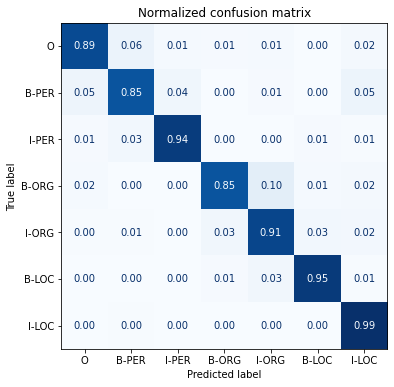

In [92]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

From the plot, we can see that our model tends to confuse the B-ORG and I-ORG entities the most. 

Otherwise, it is quite good at classifying the remaining entities, which is clear by the near diagonal nature of the confusion matrix.

In [ ]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

Now that we’ve examined the errors at the token level, let’s move on and look at **sequences** with high losses. 

In [95]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp


In [93]:
df["total_loss"] = df["loss"].apply(sum)
df_3_big_losses = df.sort_values(by="total_loss", ascending=False).head(3)
df_3_big_losses

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
3558,"[0, 242, 5106, 18141, 15020, 5106, 242, 242, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, IGN, O, O, B-LOC, I-LOC, I-LOC,...","[0.0, 0.0002703301, 0.00038485273, 3.4361548, ...","[O, O, O, B-ORG, B-ORG, O, O, O, O, B-ORG, O, ...","[<s>, ▁', ▁'', ▁Τ, Κ, ▁'', ▁', ▁', ▁'', ▁T, ▁'...",92.100091
5009,"[0, 5106, 1019, 5, 19838, 5106, 152, 75198, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-ORG, IGN, IGN, I-ORG, I-ORG, I-ORG, I-...","[0.0, 8.550853, 0.0, 0.0, 8.52665, 7.800184, 8...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[<s>, ▁'', 8, ., ▁Juli, ▁'', ▁:, ▁Protest, cam...",81.808459
4671,"[0, 14098, 145704, 19335, 157955, 91969, 3674,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, I-PER, I-PER, IGN, I-PER, IGN, I-...","[0.0, 6.258885, 5.704572, 6.2526445, 0.0, 6.13...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁United, ▁Nations, ▁Multi, dimensional, ...",64.762051


In [96]:
for sample in get_samples(df_3_big_losses):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.44,0.00,0.00,0.00,10.46,10.07,8.27,9.45,10.15,0.00,9.87,10.14,0.00,10.09,10.17,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.55,0.00,0.00,8.53,7.80,8.47,7.80,0.00,9.04,9.79,8.70,7.25,5.87,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.26,5.70,6.25,0.00,6.13,0.00,5.89,0.00,5.74,5.50,5.81,5.95,5.88,5.63,0.00


It is apparent that something is wrong with the labels of these samples; 

for example, the United Nations and the Central African Republic are each labeled as a person (last example)!

# Cross-Lingual Transfer

Now that we have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages

In [97]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
# predict() method of the Trainer
#res = trainer.predict(panx_de_encoded["test"])


# if insted of trainer, using a download model
model = AutoModelForTokenClassification.from_pretrained("GV05/xlm-roberta-base-finetuned-panx-de")
model = model.to(device)

trainer = Trainer(model=model, 
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics, 
                  tokenizer=xlmr_tokenizer)

res = trainer.predict(panx_de_encoded["test"])

In [154]:
print(res._fields)

('predictions', 'label_ids', 'metrics')


In [155]:
res.predictions.shape, res.metrics, res.label_ids.shape

((6290, 116, 7),
 {'test_loss': 0.13601349294185638,
  'test_f1': 0.8671755725190841,
  'test_runtime': 15.2055,
  'test_samples_per_second': 413.667,
  'test_steps_per_second': 51.758},
 (6290, 116))

**The German results**

In [156]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

***** Running Prediction *****
  Num examples = 6290
  Batch size = 8


F1-score of [de] model on [de] dataset: 0.867


**The French results**

In [157]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,I-PER,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,I-PER


In [158]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [159]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2290
  Batch size = 8


F1-score of [de] model on [fr] dataset: 0.696


**The Italian results**

In [160]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

***** Running Prediction *****
  Num examples = 840
  Batch size = 8


F1-score of [de] model on [it] dataset: 0.656


**The English results**

In [161]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

***** Running Prediction *****
  Num examples = 590
  Batch size = 8


F1-score of [de] model on [en] dataset: 0.594


So far we’ve seen that fine-tuning XLM-R on the German corpus yields an F1-score of around 85%, and without any additional training the model is able to achieve modest performance on the other languages in our corpus. 

The question is, how good are these results and how do they compare against an XLM-R model fine-tuned on a monolingual corpus?

In [107]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, 
                      args=training_args,
                      data_collator=data_collator, 
                      compute_metrics=compute_metrics,
                      train_dataset=train_ds, 
                      eval_dataset=valid_ds, 
                      tokenizer=xlmr_tokenizer)
    trainer.train()
    
    if training_args.push_to_hub:
        print("should not be here")
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [ ]:
panx_ch["fr"]["train"]

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 4580
})

In [99]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [100]:
panx_fr_encoded["train"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4580
})

In [ ]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)

In [109]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.492500,1.051098,0.185071
2,0.899900,0.705176,0.569553
3,0.587300,0.584122,0.618641


Epoch,Training Loss,Validation Loss,F1
1,1.205300,0.606873,0.550045
2,0.481400,0.425944,0.702297
3,0.330100,0.390302,0.704059


Epoch,Training Loss,Validation Loss,F1
1,0.805700,0.408441,0.737765
2,0.331000,0.350425,0.780576
3,0.217100,0.333629,0.810279


Epoch,Training Loss,Validation Loss,F1
1,0.605400,0.337464,0.781681
2,0.271200,0.285458,0.813073
3,0.182100,0.287294,0.833361


In [110]:
metrics_df

,num_samples,f1_score
0,250,0.167937
1,500,0.622794
2,1000,0.707824
3,2000,0.806472
4,4000,0.842882


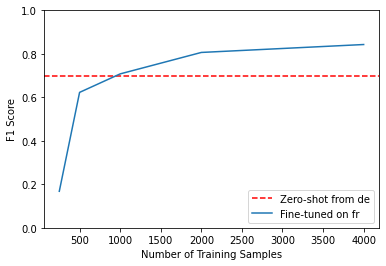

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.title("French Corpus Results")
plt.show()

# Fine-Tuning on Multiple Languages at Once

In [113]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
        
    return multi_corpus

In [114]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])
panx_de_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17160
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
})

In [125]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = False #True 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

In [ ]:
trainer.train()
#trainer.push_to_hub(commit_message="Training completed!")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.290500,0.178259,0.830973
2,0.146100,0.159958,0.845506
3,0.094800,0.165646,0.858905


TrainOutput(global_step=2145, training_loss=0.17714588014118043, metrics={'train_runtime': 671.7146, 'train_samples_per_second': 76.64, 'train_steps_per_second': 3.193, 'total_flos': 1140291491923584.0, 'train_loss': 0.17714588014118043, 'epoch': 3.0})

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("GV05/xlm-roberta-base-finetuned-panx-de-fr").to(device)

In [136]:
trainer_for_eval = Trainer(model,
                           data_collator=data_collator, 
                           compute_metrics=compute_metrics, 
                           tokenizer=xlmr_tokenizer)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [138]:
langs

['de', 'fr', 'it', 'en']

In [ ]:
res = {}
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer_for_eval)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")
    res[lang] = f1

In [141]:
res

{'de': 0.8686857272008136,
 'fr': 0.8657054916572169,
 'it': 0.7953063885267275,
 'en': 0.7017744705208929}

In [162]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8671755725190841,
              'fr': 0.6962512015379687,
              'it': 0.6555126555126556,
              'en': 0.5936435868331441}})

It performs much better on the French split than before, 

matching the performance on the German test set. 

Interestingly, its performance on the Italian and English splits also improves by roughly 10 points! 

So, even adding training data in another language improves the performance of the model on unseen languages.

In [163]:
# train for every lang and test on the other
corpora = [panx_de_encoded]


for lang in langs[1:]:  # Exclude German from iteration
    training_args.push_to_hub = False
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.575400,0.322114,0.795012
2,0.260700,0.288765,0.822458
3,0.175100,0.274793,0.840638


Epoch,Training Loss,Validation Loss,F1
1,0.812300,0.326728,0.741754
2,0.283200,0.269366,0.800647
3,0.176600,0.256364,0.821940


Epoch,Training Loss,Validation Loss,F1
1,1.133300,0.584870,0.456833
2,0.510900,0.414903,0.660773
3,0.366800,0.393775,0.691152


In [164]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8671755725190841,
              'fr': 0.6962512015379687,
              'it': 0.6555126555126556,
              'en': 0.5936435868331441},
             'fr': {'fr': 0.8398268398268399},
             'it': {'it': 0.8157669237360755},
             'en': {'en': 0.7028604786923526}})

In [165]:
corpora_encoded = concatenate_splits(corpora)
corpora_encoded 

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
})

In [ ]:
training_args

In [173]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"
training_args.push_to_hub = True

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, 
                  train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])



/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all into local empty directory.


In [174]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.308200,0.196601,0.802893
2,0.158300,0.172208,0.840346
3,0.100800,0.173848,0.852075


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   1%|          | 32.0k/4.83M [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all
   7b6d466..d5e9d36  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all
   7b6d466..d5e9d36  main -> main

To https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all
   d5e9d36..f4a5b4b  main -> main

   d5e9d36..f4a5b4b  main -> main



'https://huggingface.co/GV05/xlm-roberta-base-finetuned-panx-all/commit/d5e9d364b2579d7581540861f71fcff18ae50217'

In [175]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [177]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8671755725190841,
              'fr': 0.6962512015379687,
              'it': 0.6555126555126556,
              'en': 0.5936435868331441},
             'fr': {'fr': 0.8398268398268399},
             'it': {'it': 0.8157669237360755},
             'en': {'en': 0.7028604786923526},
             'all': {'de': 0.8633953750705019,
              'fr': 0.8654592496765848,
              'it': 0.8656195462478184,
              'en': 0.7666863555818074}})

In [176]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8672,0.6963,0.6555,0.5936
each,0.8672,0.8398,0.8158,0.7029
all,0.8634,0.8655,0.8656,0.7667
